 # What is flow ranking?
 TODO: explain the goal of finding a latent ordering, comparing between graphs

 TODO: explain some of the math behind spring rank/signal flow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from tqdm import tqdm

import SpringRank as sr
from giskard.plot import histplot
from pkg.flow import estimate_spring_rank_P
from pkg.io import savefig
from pkg.plot import set_theme
from src.visualization import adjplot

set_theme()

rng = np.random.default_rng(seed=8888)


def stashfig(name, **kwargs):
    savefig(name, foldername="what_is_flow_rank", **kwargs)



/Users/bpedigo/miniconda3/envs/maggot-revamp/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


 ## Creating latent "ranks" or "orderings"
 Here I sample some latent ranks that we'll use for simulations, this distribution came
 from the original paper.

Saved figure to maggot_connectome/results/figs/what_is_flow_rank/rank-distribution.png


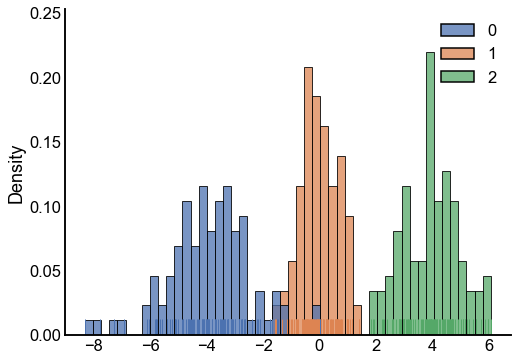

In [2]:

colors = sns.color_palette("deep", desat=1)
palette = dict(zip(range(3), colors))

n_per_group = 100  # 34 in the paper
ones = np.ones(n_per_group, dtype=int)

X1 = rng.normal(-4, np.sqrt(2), size=n_per_group)
X2 = rng.normal(0, np.sqrt(1 / 2), size=n_per_group)
X3 = rng.normal(4, 1, size=n_per_group)
X = np.concatenate((X1, X2, X3))
labels = np.concatenate((0 * ones, 1 * ones, 2 * ones))

# sort to help visualize
sort_inds = np.argsort(-X)
X = X[sort_inds]
labels = labels[sort_inds]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(x=X, hue=labels, palette=palette, bins=50, stat="density", ax=ax)
sns.rugplot(
    x=X,
    hue=labels,
    palette=palette,
    height=0.05,
    legend=False,
    ax=ax,
    expand_margins=True,
)
stashfig("rank-distribution")


 ## A distribution from the latent ranks
 Using the ranks, we can create a distribution from which to sample graphs. Here I plot
 the matrix of edge probabilities $P$ and an adjacency matrix $A$ from it.

Saved figure to maggot_connectome/results/figs/what_is_flow_rank/p-and-adj.png


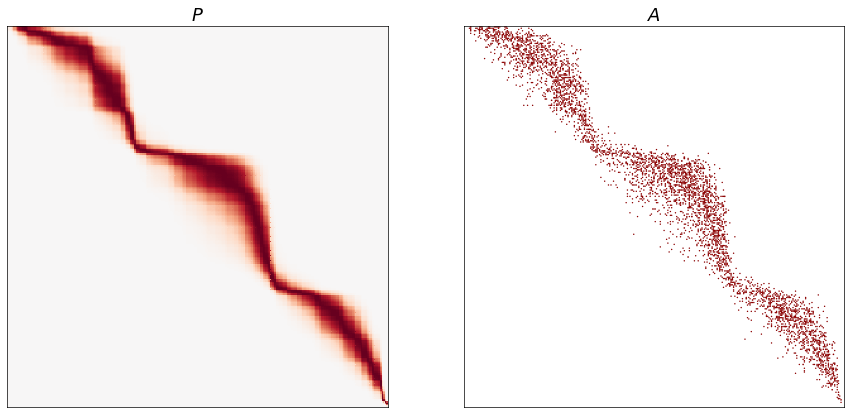

In [3]:
k = 15
beta = 5


def construct_spring_rank_P(ranks, beta, degree):
    H = ranks[:, None] - ranks[None, :] - 1
    H = np.multiply(H, H)
    H *= 0.5
    P = np.exp(-beta * H)
    P /= np.mean(P) * len(P)
    P *= degree
    # TODO not sure this matches the paper exactly but makes sense to me
    return P


P = construct_spring_rank_P(X, beta, k)
A = rng.poisson(P)

fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
ax = axs[0]
adjplot(P, ax=ax, title=r"$P$", cbar=False)
ax = axs[1]
adjplot(A, ax=ax, title=r"$A$", color="darkred", plot_type="scattermap", sizes=(2, 5))
stashfig("p-and-adj")


 If we change the parameters to be point masses for the 3 different groups, we get
 a specific kind of feedforward SBM model.

Saved figure to maggot_connectome/results/figs/what_is_flow_rank/p-and-adj-point-mass.png


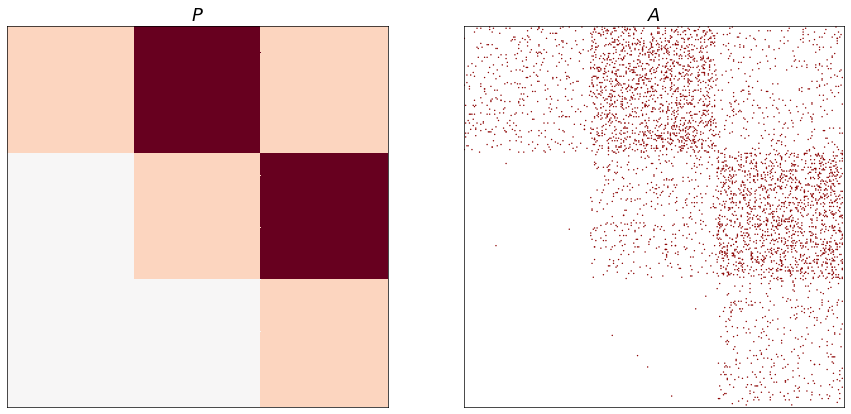

In [4]:
n_per_group = 100
X1 = np.ones(n_per_group)
X2 = np.ones(n_per_group) * 0
X3 = np.ones(n_per_group) * -1
X = np.concatenate((X1, X2, X3))
labels = np.concatenate((0 * ones, 1 * ones, 2 * ones))

k = 15
beta = 3

P = construct_spring_rank_P(X, beta, k)
A = rng.poisson(P)

fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
ax = axs[0]
adjplot(P, ax=ax, title=r"$P$", cbar=False)
ax = axs[1]
adjplot(A, ax=ax, title=r"$A$", color="darkred", plot_type="scattermap", sizes=(2, 5))
stashfig("p-and-adj-point-mass")



 ## Are the ranks of $G_1$ "the same" as the ranks of $G_2$?
 If we are given two graphs (with an alignment/matching between the nodes of the two
 graphs) we may want to know whether the latent ranks $s$ of the two graphs are the same.

 $$ H_0: s_1 = s_2 $$
 $$ H_a: s_1 \neq s_2 $$

 A boostrap procedure (welcome to feedback) to get at this question:
 - Estimate the ranks from $G_1$, $G_2$
 - Compute some test statistic ($T(s_1, s_2)$) measuring the distance between these
 rankings. Examples include some notion of correlation between the ranks. The SpringRank
 paper also includes a metric based on the energy of the system they define, which is
 a function of the ranks.
 - For i in a bunch of times:
    - Sample 2 graphs from the same ranks, $s_1$, call them $\tilde{G^1_1}, \tilde{G_1^2}$.
    - Compute ranks of both, $\tilde{s_1^1}$ and $\tilde{s_1^2}$.
    - Compute $T(\tilde{s_1^1}, \tilde{s_1^2})$
    - Do the above 3 steps for $s_2$, yielding $T(\tilde{s_2^1}, \tilde{s_2^2})$
    - Append $max(T(\tilde{s_1^1}, \tilde{s_1^2}), T(\tilde{s_2^1}, \tilde{s_2^2}))$ to
      null distribution.
 - Compare $T(s_1, s_2)$ to null distribution to get a p-value.

 NB: there is a nonidentifiability in the notion of ranks that we don't care about.
 shifting the ranks up or down by a constant does not affect the resulting distribution
 on graphs. Here I've just chosen a test statistic (correlation) that happens to not
 care about this, but it's worth being aware of.

 ## Power simulations
 Here I sample latent ranks $s_1$ from the distribution described/plotted above. The
 ranks $s_2 = s_1 + \epsilon$, where $\epsilon \sim N(0, \sigma^2 I)$, that is,
 I perturb the ranks $s_1$ by independent normals for each rank, with some variance
 $\sigma^2$.

 This process is repeated, multiple times for each $\sigma$ and for increasing levels
 of $\sigma$. I then run the bootstrap two sample testing procedure described above for
 each realization, and examine the distribution of p-values.

Sigma = 0.35: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]
Saved figure to maggot_connectome/results/figs/what_is_flow_rank/compare-to-null-sigma=0.35.png
Saved figure to maggot_connectome/results/figs/what_is_flow_rank/p-values.png
Saved figure to maggot_connectome/results/figs/what_is_flow_rank/p-values-null.png


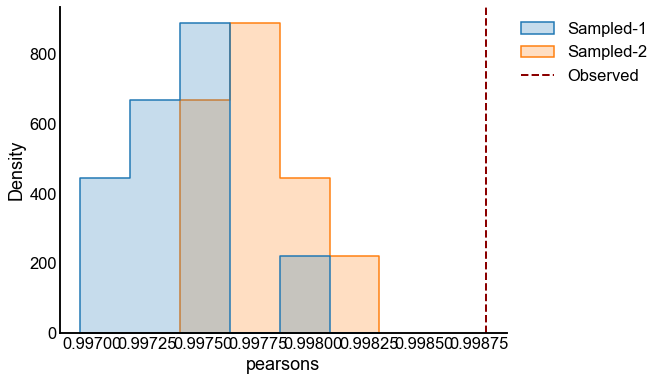

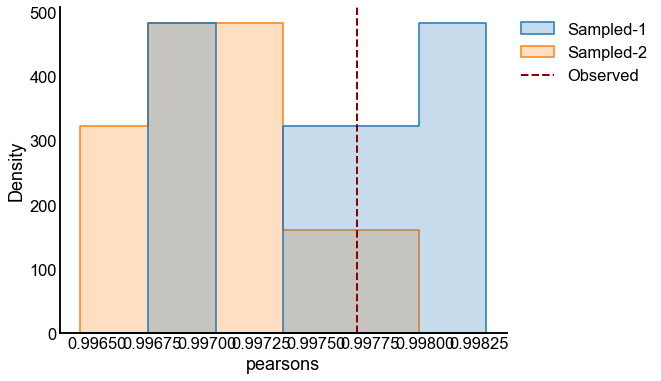

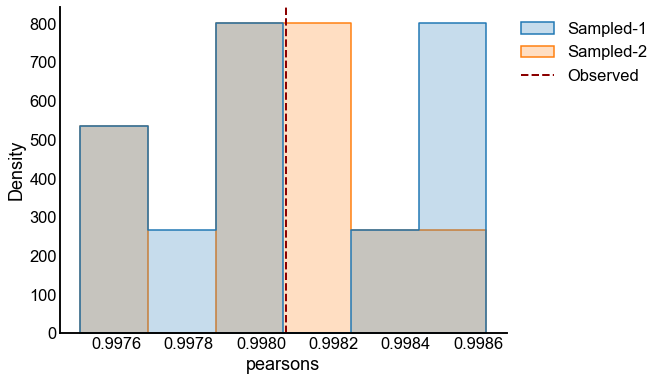

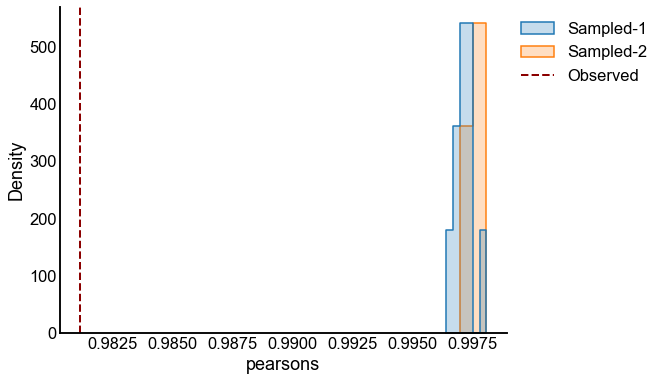

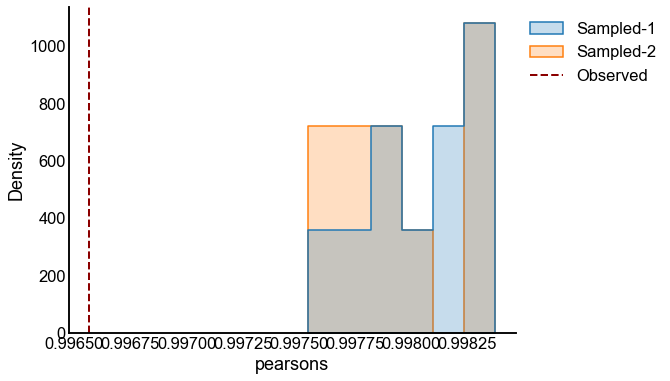

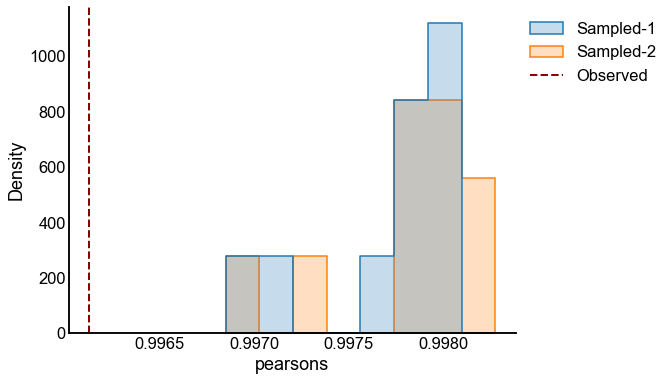

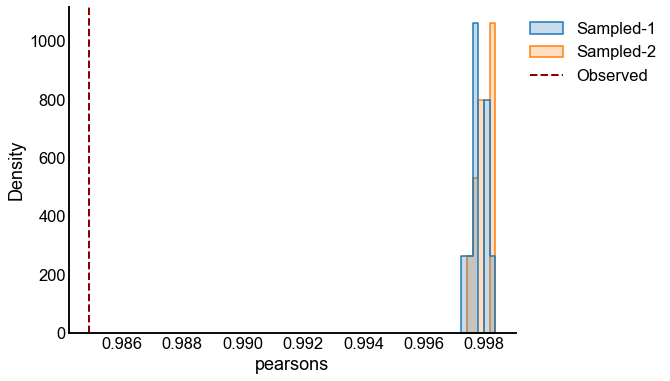

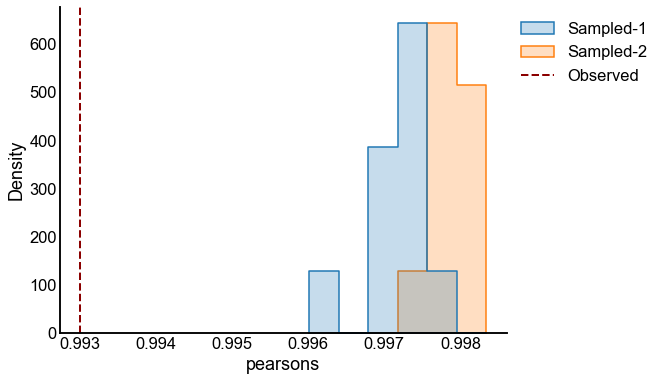

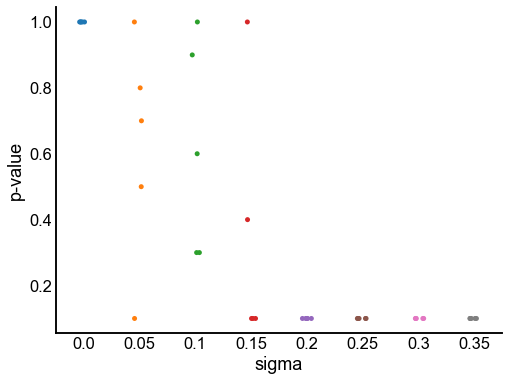

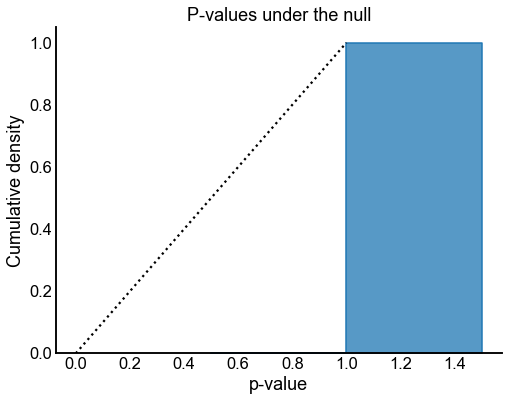

In [5]:


def make_ranks(n_per_group=34):
    """Based on simulations from original spring rank paper"""
    X1 = rng.normal(-4, np.sqrt(2), size=n_per_group)
    X2 = rng.normal(0, np.sqrt(1 / 2), size=n_per_group)
    X3 = rng.normal(4, 1, size=n_per_group)
    X = np.concatenate((X1, X2, X3))
    return X


def estimate_spring_rank_model(A):
    ranks = sr.get_ranks(A)
    beta = sr.get_inverse_temperature(A, ranks)
    Phat = estimate_spring_rank_P(A, ranks, beta)
    return ranks, beta, Phat


statistics = ["pearsons"]


def calculate_test_statistics(ranks1, ranks2):
    pearsons = pearsonr(ranks1, ranks2)[0]
    return {"pearsons": pearsons}


def bootstrap_sample(Phat):
    A1_tilde = rng.poisson(Phat)
    A2_tilde = rng.poisson(Phat)
    ranks_A1_tilde = sr.get_ranks(A1_tilde)
    ranks_A2_tilde = sr.get_ranks(A2_tilde)

    # calculate test statistic(s)
    test_statistics = calculate_test_statistics(ranks_A1_tilde, ranks_A2_tilde)
    return test_statistics


def bootstrap_two_sample_test(A1, A2, n_bootstraps=200):
    ranks1, beta1, Phat1 = estimate_spring_rank_model(A1)
    ranks2, beta2, Phat2 = estimate_spring_rank_model(A2)
    observed_test_statistics = calculate_test_statistics(ranks1, ranks2)
    observed_test_statistics["graph"] = "Observed"
    rows = [observed_test_statistics]
    for i in range(n_bootstraps):
        test_statistics = bootstrap_sample(Phat1)
        test_statistics["graph"] = "Sampled-1"
        rows.append(test_statistics)

        test_statistics = bootstrap_sample(Phat2)
        test_statistics["graph"] = "Sampled-2"
        rows.append(test_statistics)

    results = pd.DataFrame(rows)

    p_values = []
    for test_statistic_name in statistics:
        observed_test_statistic = results[results["graph"] == "Observed"][
            test_statistic_name
        ].iloc[0]
        null1 = results[results["graph"] == "Sampled-1"][test_statistic_name]
        p_value1 = np.count_nonzero(null1 < observed_test_statistic) / len(null1)
        if p_value1 == 0:
            p_value1 = 1 / n_bootstraps
        null2 = results[results["graph"] == "Sampled-1"][test_statistic_name]
        p_value2 = np.count_nonzero(null2 < observed_test_statistic) / len(null2)
        if p_value2 == 0:
            p_value2 = 1 / n_bootstraps
        # use the max of the p-values, extra conservative
        p_value = max(p_value1, p_value2)
        p_values.append(p_value)
    return p_values, results


n_per_group = 34
# n_bootstraps = 200
# n_repeats = 100
n_bootstraps = 10
n_repeats = 5
sigmas = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
experiments = {}
p_value_distribution = []
for sigma in sigmas:
    for repeat in tqdm(range(n_repeats), desc=f"Sigma = {sigma}"):
        X = make_ranks(n_per_group=n_per_group)
        P = construct_spring_rank_P(X, beta, k)
        A1 = rng.poisson(P)

        X_perturbed = X + rng.normal(scale=sigma, size=len(X))
        P_perturbed = construct_spring_rank_P(X_perturbed, beta, k)
        A2 = rng.poisson(P_perturbed)

        p_values, results = bootstrap_two_sample_test(A1, A2, n_bootstraps=n_bootstraps)
        experiments[(sigma, repeat)] = (p_values, results)
        p_value_distribution.append(
            {"sigma": sigma, "repeat": repeat, "p-value": p_values[0]}
        )

    # plot one set of nulls at each sigma
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    histplot(
        data=results, x="pearsons", hue="graph", ax=ax, stat="density", element="step"
    )
    stashfig(f"compare-to-null-sigma={sigma}")

p_value_distribution = pd.DataFrame(p_value_distribution)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.stripplot(data=p_value_distribution, x="sigma", y="p-value", ax=ax)
stashfig("p-values")

p_values_under_null = p_value_distribution[p_value_distribution["sigma"] == 0]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(
    data=p_values_under_null,
    x="p-value",
    cumulative=True,
    stat="density",
    ax=ax,
    element="step",
    bins=40,
)
ax.plot([0, 1], [0, 1], color="black", linestyle=":")
ax.set(title="P-values under the null", ylabel="Cumulative density")
stashfig("p-values-null")


 ## Valid and power goes to 1?
 At least from the above simulation, it looks like:
 - The p-values are sub-uniform under the null
 - The p-values go to 0 as the effect size goes up

 ## If the ranks of $G_1$ and $G_2$ are not "the same", how are they related?
 More specifically, do the ranks of $G_1$ point in a completely opposite direction
 as those of $G_2$? z